# 线性回归的从零开始实现


我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器。

虽然现代的深度学习框架几乎可以自动化地进行所有这些工作，但从零开始实现可以确保你真正知道自己在做什么。

In [27]:
%matplotlib inline
import random

import torch
from d2l import torch as d2l

## 生成数据集

根据带有噪声的线性模型构造一个人造数据集。

我们使用线性模型参数$\mathbf{w} = [2, -3.4]^T$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：
$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$


In [28]:
def synthetic_data(w, b, num_examples):  # @save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [29]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

通过生成第二个特征`features[:, 1]`和`labels`的散点图，
可以直观观察到两者之间的线性关系。


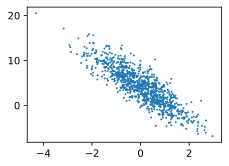

In [30]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

## 读取数据集

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，
该函数能打乱数据集中的样本并以小批量方式获取数据。


In [31]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i : min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [32]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, "\n", y)
    break

tensor([[ 0.1399, -0.6505],
        [ 0.0092, -2.1590],
        [-0.1682, -0.0672],
        [ 1.7774, -1.0387],
        [-0.2359, -0.0095],
        [ 1.1942,  0.6214],
        [ 0.0913,  1.4084],
        [-0.7619,  1.4625],
        [-0.8764, -0.5626],
        [-0.2592,  1.1125]]) 
 tensor([[ 6.6709],
        [11.5497],
        [ 4.0829],
        [11.2797],
        [ 3.7647],
        [ 4.4886],
        [-0.4036],
        [-2.2978],
        [ 4.3479],
        [-0.0963]])




## 初始化模型参数

在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，
并将偏置初始化为0。


In [33]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)



## 定义模型

回想一下，要计算线性模型的输出，
我们只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。




In [34]:
def linreg(X, w, b):  # @save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## 定义损失函数

In [35]:
def squared_loss(y_hat, y):  # @save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法

因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（`batch_size`）
来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。


In [36]:
def sgd(params, lr, batch_size):  # @save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练

* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个*迭代周期*（epoch）中，我们使用`data_iter`函数遍历整个数据集，
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。


In [37]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [38]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f"epoch {epoch + 1}, loss {float(train_l.mean()):f}")

epoch 1, loss 0.030965
epoch 2, loss 0.000112
epoch 3, loss 0.000052


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。

因此，我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度


In [39]:
print(f"w的估计误差: {true_w - w.reshape(true_w.shape)}")
print(f"b的估计误差: {true_b - b}")

w的估计误差: tensor([-0.0002,  0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)


幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。
其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

## 练习

1. 为什么在`squared_loss`函数中需要使用`reshape`函数？

（提示：其实不需要，因为`w`的`shape`为`[2, 1]`）